# MODELOS DE PREVISÃO PARA CASOS DE DENGUE

# MINAS GERAIS - BRASIL

# ANO: 2022

**TEXTO**

**SUBIR PARA O GITHUB E PASSAR E-MAIL**

**ADICIONAR 2022 PARA VALIDAÇÃO**

**EXTRA: DADOS PLUVIOMÉTRICOS COM VAR E PROPHET**

**EXTRA: OUTRAS VARIÁVEIS COM FILTRO**


## Clonando o repositório com os dados do problema

In [10]:
!rm -r IEC.PUC.Modelo.Notif.Dengue
!git clone https://github.com/cgalmeida/IEC.PUC.Modelo.Notif.Dengue.git

Cloning into 'IEC.PUC.Modelo.Notif.Dengue'...
remote: Enumerating objects: 900, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 900 (delta 38), reused 57 (delta 6), pack-reused 768
Receiving objects: 100% (900/900), 103.58 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (238/238), done.
Checking out files: 100% (579/579), done.


## Instalando pacotes

**Otimizador**

In [11]:
! pip install adabelief-tf --quiet

**Auto Arima**

In [12]:
! pip install pmdarima --quiet

**SciKit Forecasting**

In [13]:
! pip install sktime --quiet

## Fazendo os imports das libs necessárias

In [14]:
import os
from io import StringIO
import codecs
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from adabelief_tf import AdaBeliefOptimizer
import random as python_random
from sktime.utils.plotting import plot_series
import warnings

warnings.filterwarnings("ignore")

## Leitura dos dados

In [15]:
path_data = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'processados')
path_data

'IEC.PUC.Modelo.Notif.Dengue/dados/processados'

In [16]:
filename = 'dengue_mg.csv'
full_fn = os.path.join(path_data, filename)
data_list = pd.read_csv(full_fn, sep=';', encoding='latin-1')
data = data_list['Casos'].values.tolist()

## Processando o dado

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))

def exec_scaler(ds):
    data = [[i] for i in ds]
    print('shape: ', np.array(data).shape)
    return scaler.fit_transform(data)

In [23]:
dataframe =  data_list['Casos']

dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = exec_scaler(dataset)

shape:  (180, 1)


**Valores originais**

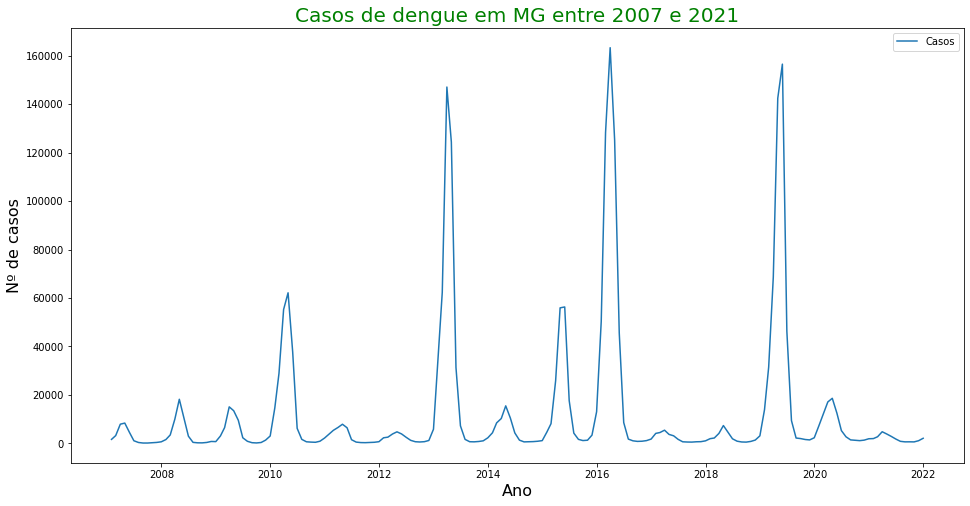

In [24]:
%matplotlib inline

y = pd.DataFrame(data=dataframe.values, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

font_title = {'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'}
font_label = {'fontsize': 16, 'fontweight' : 5, 'color' : 'Black'}
plt.figure(figsize=(16,8))
plt.plot(y, label='Casos')
plt.legend(loc='best')
plt.title('Casos de dengue em MG entre 2007 e 2021', fontdict=font_title)
plt.xlabel('Ano', fontdict=font_label)
plt.ylabel('Nº de casos', fontdict=font_label)
plt.show()

**Valores escalonados**

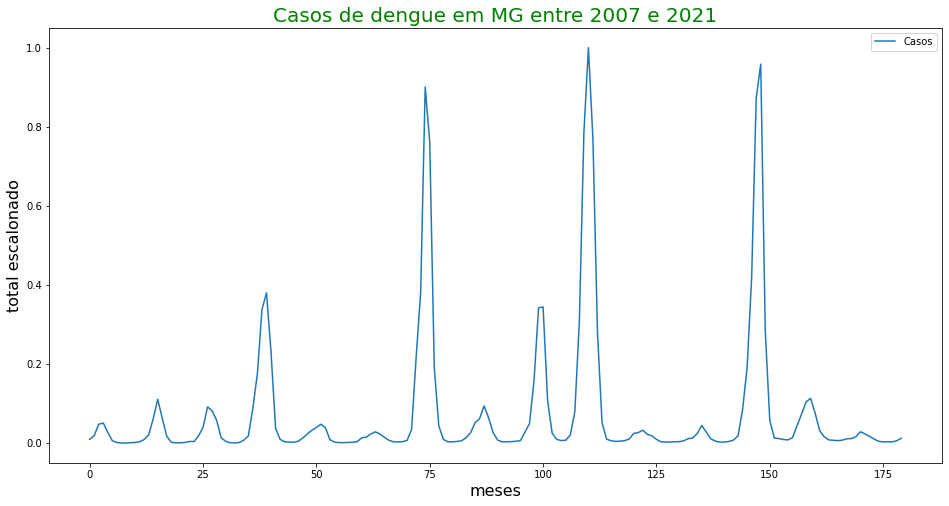

In [25]:
%matplotlib inline

font_title = {'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'}
font_label = {'fontsize': 16, 'fontweight' : 5, 'color' : 'Black'}
plt.figure(figsize=(16,8))
plt.plot(dataset, label='Casos')
plt.legend(loc='best')
plt.title('Casos de dengue em MG entre 2007 e 2021', fontdict=font_title)
plt.xlabel('meses', fontdict=font_label)
plt.ylabel('total escalonado', fontdict=font_label)
plt.show()

## Examinando as características da série

In [26]:
y = pd.DataFrame(data=dataframe.values, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))
y.columns = ['Casos']
y.head()

,Casos
2007-01-31,1625
2007-02-28,3189
2007-03-31,7899
2007-04-30,8351
2007-05-31,4547


**Additive seasonal decomposition**

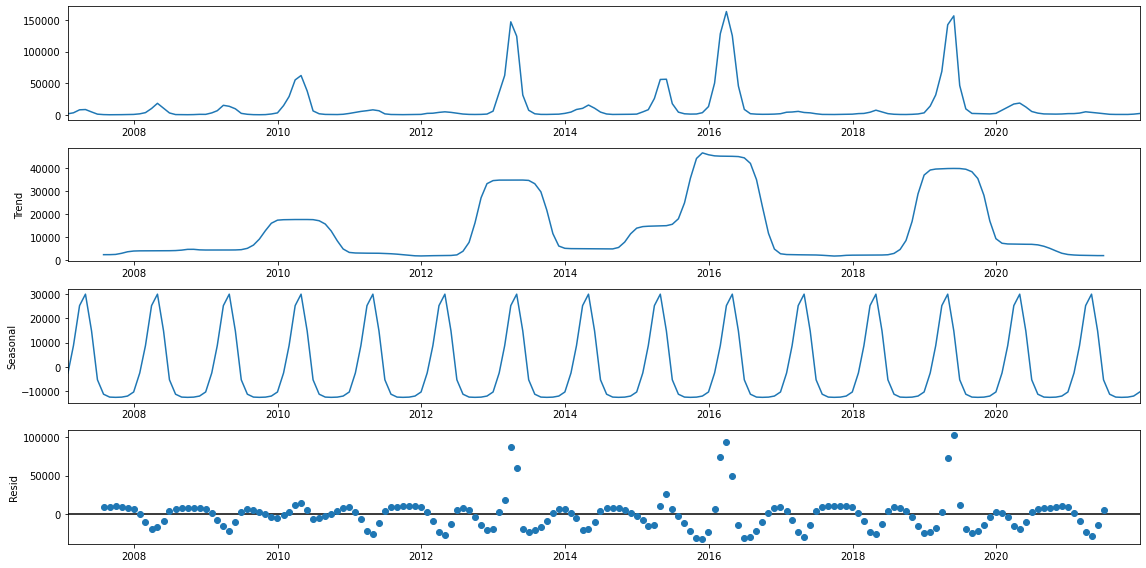

In [27]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

**Multiplicative seasonal decomposition**

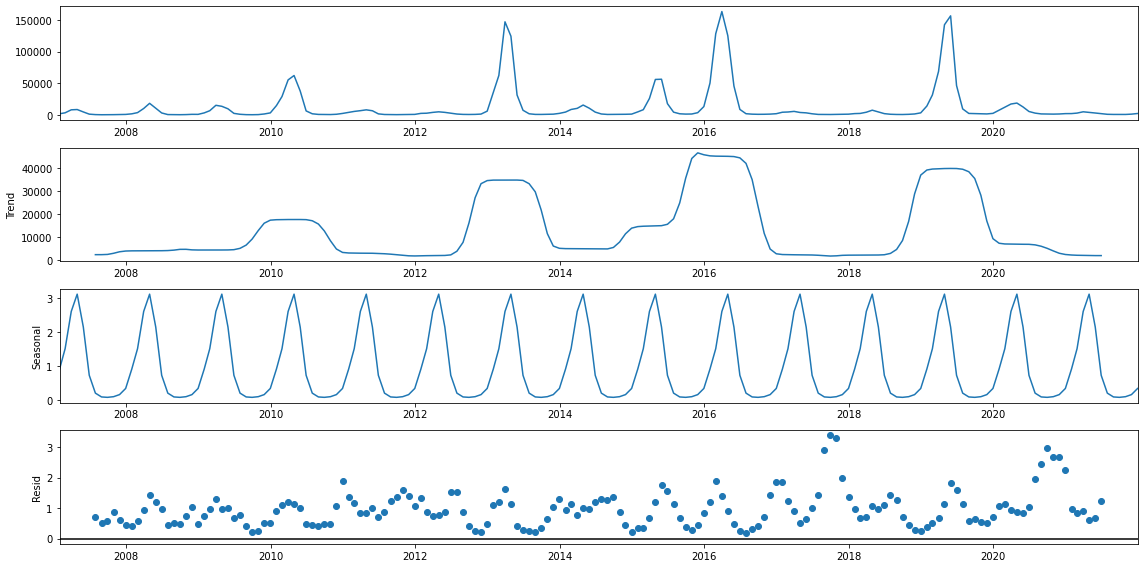

In [28]:
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

**Observações:**

**O dado possui sazonalidade. Ainda não é possível afirmar que exibe uma tendência.** 

**O dado residual após a decomposição aditiva possui menor variação.**

### Resumo estatístico

**VALORES ORIGINAIS**

In [29]:
X = y['Casos'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=9736.588889, mean2=15182.244444
variance1=514841815.597654, variance2=1161913739.762470


**VALORES ESCALONADOS**

In [30]:
X = dataset
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.058937, mean2=0.092302
variance1=0.019326, variance2=0.043616


## Verificar tendência

**Augmented Dickey-Fuller (ADF) test**

In [31]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y['Casos'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -6.050121
Critical Values @ 0.05: -2.88
p-value: 0.000000


**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**

In [32]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(y['Casos'], nlags="legacy")

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.123347
Critical Values @ 0.05: 0.46
p-value: 0.100000


**Aplicando BOX COX aos dados para tornar a série estacionária**

**(Modelos de Auto Regressão)**

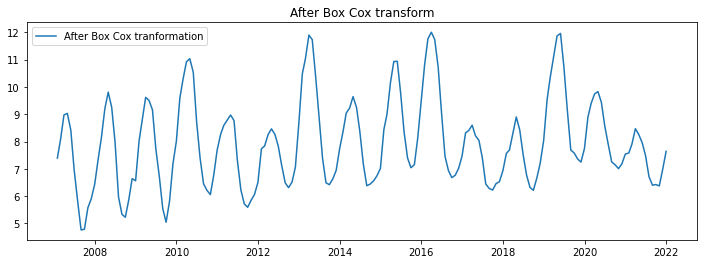

In [33]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(y['Casos'], lmbda=0), index = y.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

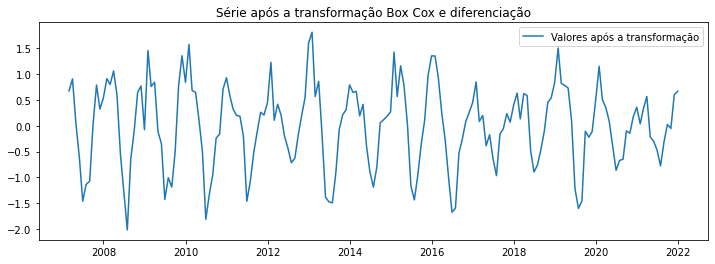

In [34]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), y.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='Valores após a transformação')
plt.legend(loc='best')
plt.title('Série após a transformação Box Cox e diferenciação')
plt.show()

In [35]:
data_boxcox_diff.dropna(inplace=True) # After shifting the data, drop the first value which is NA

**Reaplicando os testes**

In [36]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.299059
Critical Values @ 0.05: -2.88
p-value: 0.014921


In [37]:
kpss_test = kpss(data_boxcox_diff, nlags="legacy")

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.042030
Critical Values @ 0.05: 0.46
p-value: 0.100000


## Separando o dado em treino e teste

In [38]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
print(train_size, test_size)

120 60


In [39]:
train_df = y[:train_size]
test_df = y[train_size:]

In [40]:
train_data_boxcox = data_boxcox[:train_size]
test_data_boxcox = data_boxcox[train_size:]
train_data_boxcox_diff = data_boxcox_diff[:train_size-1]
test_data_boxcox_diff = data_boxcox_diff[train_size-1:]

## Avaliação

In [53]:
path_res = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'code', 'results', 'resultados.xls')
path_res

'IEC.PUC.Modelo.Notif.Dengue/code/results/resultados.xls'

In [88]:
metrics = {'model': [],
           'rmse': [],
           'mae': [],
           'mape':[]
}

def export_metrics():
    df = pd.DataFrame(metrics)
    df.to_excel(path_res)

def add_metric(ds_model, y_true, y_pred, y_true_val, y_pred_val):
    val_rmse = mean_squared_error(y_true, y_pred, squared=True)
    val_mae = mean_absolute_error(y_true, y_pred)
    val_mape = mean_absolute_percentage_error(y_true_val, y_pred_val)
    metrics['model'].append(ds_model)    
    metrics['rmse'].append(val_rmse)
    metrics['mae'].append(val_mae)
    metrics['mape'].append(val_mape)
    return [val_rmse, val_mae, val_mape]

## Visualização

In [43]:
def plot_serie(dataset, x_pred, y_pred, look_back):
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = x_pred

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)-1:len(dataset)-1, :] = y_pred

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

# Modelos de Autoregressão

In [44]:
# Executado apenas 1 vez para determinar os parâmetros ideais

#from pmdarima import arima as pm

# Fit a simple auto_arima model
#arima = pm.auto_arima(train_data_boxcox, error_action='ignore', trace=True,
#                      suppress_warnings=True, maxiter=10,
#                      seasonal=True, m=36)

# y_pred_arima = arima.predict(n_periods=test.shape[0])

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(3, 0, 2), seasonal_order=(2, 0, 1, 36)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.448639
ar.L2       0.902060
ar.L3      -0.390313
ma.L1       1.005419
ma.L2       0.084244
ar.S.L36    0.147237
ar.S.L72    0.683379
ma.S.L36    0.302456
sigma2      0.117827
dtype: float64


In [46]:
# Recover original time series forecast
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

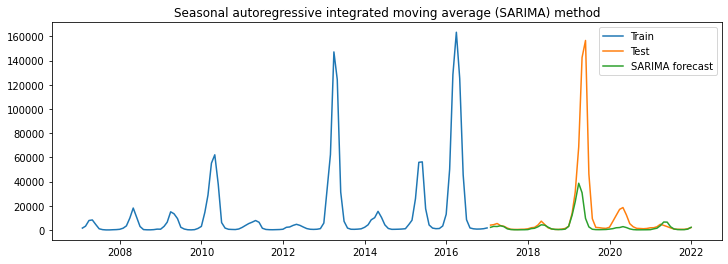

In [47]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train_df['Casos'], label='Train')
plt.plot(test_df['Casos'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_df.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [48]:
y_test_val = np.reshape(test_df.values, (len(test_df)))
y_pred_val = np.reshape(y_hat_sarima['sarima_forecast'][test_df.index.min():].values, (len(test_df)))

y_test = exec_scaler(y_test_val)
y_pred = exec_scaler(y_pred_val)
add_metric('SARIMA', y_test, y_pred, y_test_val, y_pred_val)

shape:  (60, 1)
shape:  (60, 1)


[0.021078146844330296, 0.06236888703739397, 0.5252189193187388]

# Modelo de Rede Neural Recorrente

## Funções auxiliares

In [49]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_convergence(hist: tf.keras.callbacks.History, 
                     metric_name:str) -> None:
  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')
  
  ax = plt.axes()
  ax.set_facecolor("darkgrey")
  
  plt.xlabel('Epoch', fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylabel(metric_name.title(), fontsize=14)
  plt.yticks(fontsize=14)

  plt.plot(range(1, len(hist.history[metric_name.lower()]) + 1), 
           hist.history[metric_name.lower()], marker='o', linewidth=3, 
           markersize=12)
  plt.plot(range(1, len(hist.history[f'val_{metric_name.lower()}']) + 1), 
           hist.history[f'val_{metric_name.lower()}'], marker='X', linewidth=3, 
           markersize=12)
  plt.legend([metric_name.title(), f'Validation {metric_name.title()}'], 
             fontsize=14)
  plt.show()

def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

## Taxa de aprendizagem do otimizador

In [50]:
learning_rate = 1e-3
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

## Preparando o dado

In [51]:
look_back = 9

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

120 60


## Criando, compilando e treinando o modelo de Redes Neurais Recorrentes

In [52]:
%%time
# Criando o modelo
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))

# Compilando o modelo
model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

hist = model.fit(trainX,
                 trainY,
                 epochs=200,
                 batch_size=128,
                 validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0233 - val_loss: 0.1158
Epoch 2/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0233 - val_loss: 0.1157
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0232 - val_loss: 0.1157
Epoch 4/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0232 - val_loss: 0.1156
Epoch 5/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0232 - val_loss: 0.1156
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0232 - val_loss: 0.1155
Epoch 7/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0232 - val_loss: 0.1155
Epoch 8/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0232 - val_loss: 0.1154
Epoch 9/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0231 - val_loss: 0.1153
Epoch 10/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0231 - val_loss: 0.1152
Epoch 11/200
1/1 [===

## Visualizando a rede

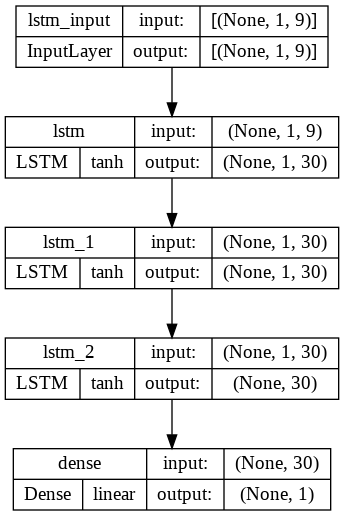

In [55]:
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, 
                      to_file=dot_img_file, 
                      show_shapes=True, 
                      show_layer_activations=True)

## Plotando a convergência

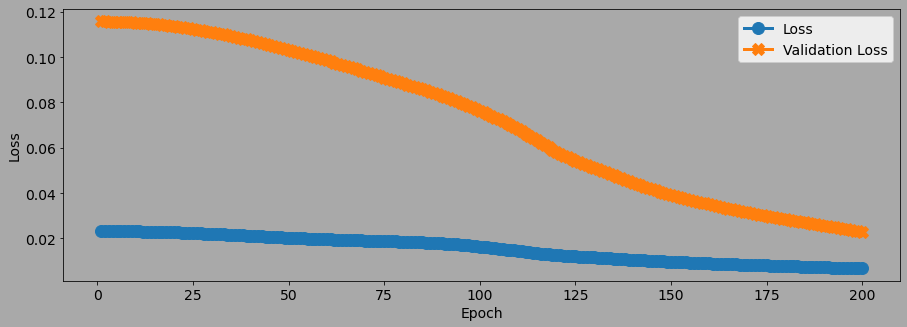

In [56]:
plot_convergence(hist, 'loss')

## Fazendo as predições para os dados

In [80]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_v = scaler.inverse_transform(trainPredict)
trainY_v = scaler.inverse_transform([[i] for i in trainY])
testPredict_v = scaler.inverse_transform(testPredict)
testY_v = scaler.inverse_transform([[i] for i in testY])

2/2 [==============================] - 0s 6ms/step


## Avaliação do modelo

In [82]:
y_test = np.reshape(testY, (len(testY), 1))
y_pred = np.reshape(testPredict, (len(testY), 1))

y_test_val = np.reshape(testY_v, (len(testY), 1))
y_pred_val = np.reshape(testPredict_v, (len(testY), 1))

add_metric('Rede Neural Recorrente (LookBack=' + str(look_back) + ')', y_test, y_pred, y_test_val, y_pred_val)

[0.011288362895879254, 0.05008802336972656, 2.2704364630142333]

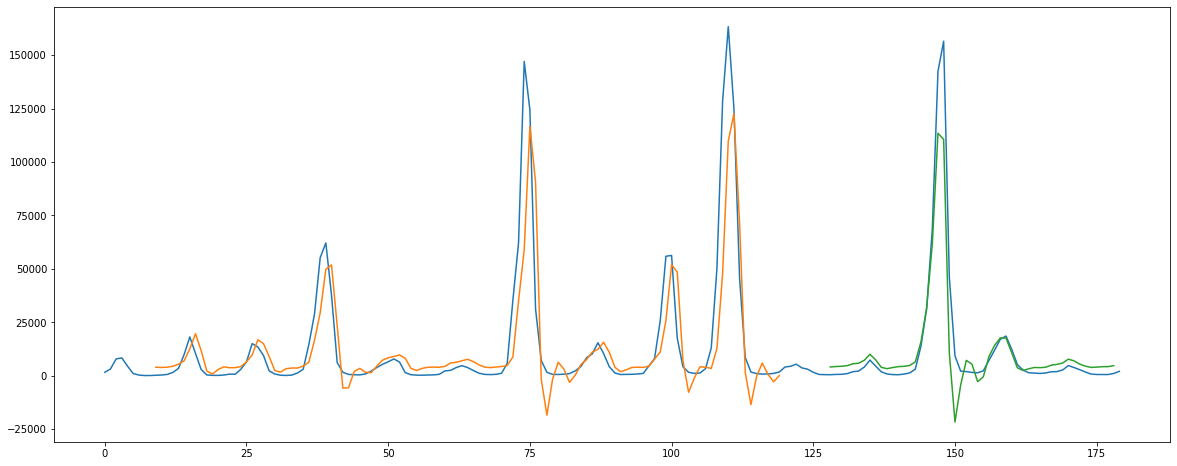

In [83]:
d = scaler.inverse_transform(dataset)
plot_serie(d, trainPredict_v, testPredict_v, look_back)

## Exportando o modelo e os pesos

In [84]:
path_model_rnn = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'code', 'models', 'model_rnn.bin')
model.save(path_model_rnn)

## Exponential Smoothing

In [89]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import temporal_train_test_split

# sktime requires to have data with a pandas.DatetimeIndex
y = pd.DataFrame(data=dataset, index=pd.date_range(start='2007-01-01', end='2021-12-31', freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=60)

val_sp = 36
forecaster = ExponentialSmoothing(trend='add', seasonal='additive', sp=val_sp)

forecaster.fit(y_train)
period = list(range(0,len(y_test)))
y_pred = forecaster.predict(fh=period)

In [97]:
# Recupera os valores originais
def inv_transf(y):
    y.columns = ['Casos']
    d = [[i] for i in y['Casos'].values]
    return scaler.inverse_transform(y)

val_y_train = inv_transf(y_train)
val_y_test = inv_transf(y_test)
val_y_pred = inv_transf(y_pred)

In [98]:
add_metric('Exponential smoothing (sp=' + str(val_sp) + ')', y_test, y_pred, val_y_test, val_y_pred)

[0.007150890475027444, 0.050550328643724794, 3.498038227454725]

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0924c0e50>)

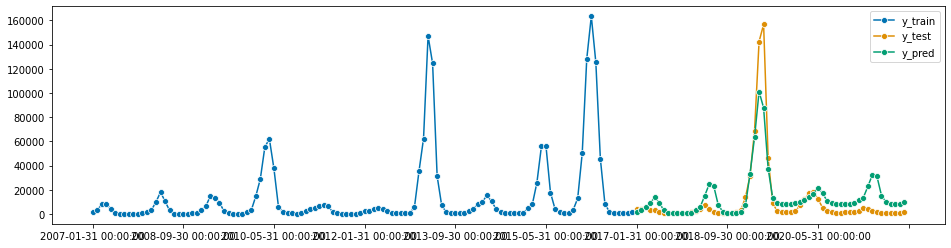

In [101]:
val_y_train = pd.DataFrame(data=val_y_train, index=pd.date_range(start='2007-01-01', end='2016-12-31', freq='M'))
val_y_test = pd.DataFrame(data=val_y_test, index=pd.date_range(start='2017-01-01', end='2021-12-31', freq='M'))
val_y_pred = pd.DataFrame(data=val_y_pred, index=pd.date_range(start='2017-01-01', end='2021-12-31', freq='M'))
plot_series(val_y_train, val_y_test, val_y_pred, labels=["y_train", "y_test", "y_pred"])

## Exportar modelo e pesos

In [103]:
import pickle

path_model_exp = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'code', 'models', 'model_exp.bin')
with open(path_model_exp, 'wb') as f:
    pickle.dump(forecaster, f)

## Exportar resultados

In [ ]:
export_metrics()

## Previsão para 2022

**Dados obtidos de fonte diferente: Fiocruz**

In [128]:
path_tmp = os.path.join(path_data, 'dengue_mg_2022.xlsx')
df_2022 = pd.read_excel(path_tmp)
df_2022 = df_2022.set_index(['Mês'])
new_df = np.concatenate((dataframe.values, df_2022['Casos'].values), axis=None)
new_df = exec_scaler(new_df)

shape:  (189, 1)


**REDE NEURAL RECORRENTE**

In [140]:
model_rnn = keras.models.load_model(path_model_rnn, custom_objects={'AdaBeliefOptimizer': ada_belief})

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [141]:
look_back = 9
train_size = 162

train, test = new_df[0:train_size,:], new_df[train_size:len(new_df),:]
print(len(train), len(test))

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

162 27


In [142]:
hist = model_rnn.fit(trainX,
                     trainY,
                     epochs=200,
                     batch_size=128,
                     validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0092 - val_loss: 0.0184
Epoch 2/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 3/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 4/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 5/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 7/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 8/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0092 - val_loss: 0.0183
Epoch 9/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0092 - val_loss: 0.0182
Epoch 10/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0092 - val_loss: 0.0182
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 17ms/step
[0.0022451843982417216, 0.03333037526067088, 1.9499233605630018]


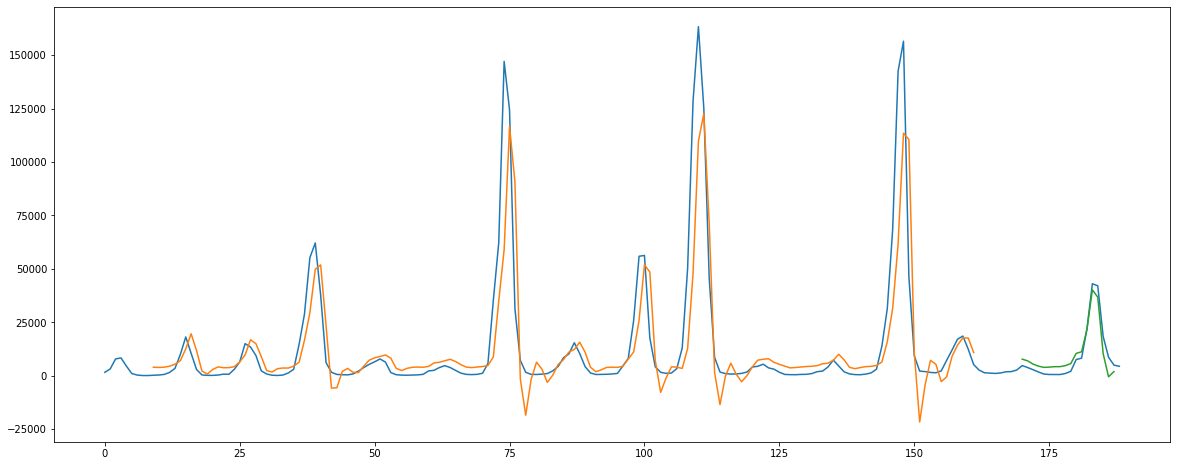

In [143]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_v = scaler.inverse_transform(trainPredict)
trainY_v = scaler.inverse_transform([[i] for i in trainY])
testPredict_v = scaler.inverse_transform(testPredict)
testY_v = scaler.inverse_transform([[i] for i in testY])

y_test = np.reshape(testY, (len(testY), 1))
y_pred = np.reshape(testPredict, (len(testY), 1))

y_test_val = np.reshape(testY_v, (len(testY), 1))
y_pred_val = np.reshape(testPredict_v, (len(testY), 1))

mtrc = add_metric('Rede Neural Recorrente (LookBack=' + str(look_back) + ')', y_test, y_pred, y_test_val, y_pred_val)
print(mtrc)

d = scaler.inverse_transform(new_df)
plot_serie(d, trainPredict_v, testPredict_v, look_back)

**EXPONENTIAL SMOOTHING**

In [134]:
import pickle

with open(path_model_exp, 'rb') as f:
	model_exp = pickle.load(f)

[0.016005016722070584, 0.07646348133963983, 2.7792318653437436]


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0961024d0>)

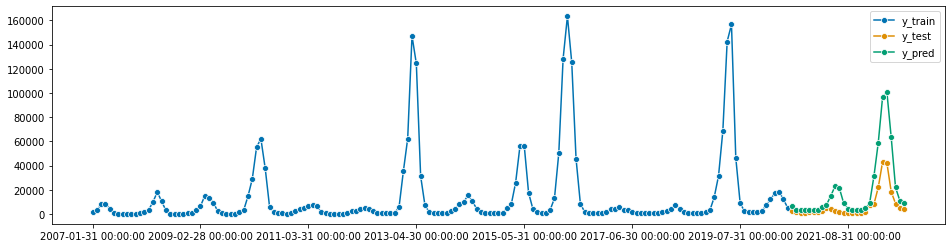

In [137]:
y = pd.DataFrame(data=new_df, index=pd.date_range(start='2007-01-01', end='2022-09-30', freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=27)

model_exp.fit(y_train)
period = list(range(0,len(y_test)))
y_pred = model_exp.predict(fh=period)

# Recupera os valores originais
def inv_transf(y):
    y.columns = ['Casos']
    d = [[i] for i in y['Casos'].values]
    return scaler.inverse_transform(y)

val_y_train = inv_transf(y_train)
val_y_test = inv_transf(y_test)
val_y_pred = inv_transf(y_pred)

mtrc = add_metric('Exponential smoothing (sp=' + str(val_sp) + ')', y_test, y_pred, val_y_test, val_y_pred)
print(mtrc)

val_y_train = pd.DataFrame(data=val_y_train, index=pd.date_range(start='2007-01-01', end='2020-06-30', freq='M'))
val_y_test = pd.DataFrame(data=val_y_test, index=pd.date_range(start='2020-07-01', end='2022-09-30', freq='M'))
val_y_pred = pd.DataFrame(data=val_y_pred, index=pd.date_range(start='2020-07-01', end='2022-09-30', freq='M'))
plot_series(val_y_train, val_y_test, val_y_pred, labels=["y_train", "y_test", "y_pred"])


## Previsão com dados meteorológicos

In [ ]:
! pip install dtw-python --quiet
! pip install pyod --quiet
! pip install hmmlearn --quiet
! pip install tsfresh --quiet
! pip install esig --quiet
! pip install tslearn --quiet
! pip install statsforecast --quiet
! pip install mne --quiet
! pip install pykalman --quiet
! pip install filterpy --quiet
! pip install stumpy --quiet

In [ ]:
from sktime.registry import all_estimators

for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
    print(forecaster[0])

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
df_data.sample(5)

,Periodo,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
57,2011.10,348,3.174717,930.829019,21.553030,73.500000
65,2012.06,2513,0.700439,935.255022,19.755323,75.500000
71,2012.12,5801,2.053104,929.568096,24.585446,70.357143
10,2007.11,365,3.054137,930.124480,23.253862,70.285714
70,2012.11,1170,5.478016,929.144507,22.406874,78.428571


In [ ]:
df = df_data.copy()
df['Datetime'] = pd.to_datetime(df['Periodo'] + '.01')
df = df.set_index('Datetime')
df = df.drop(['Periodo'], axis=1)
df.tail()

,Casos,PRECIPITACAO,PRESSAO_ATM,TEMPERATURA,UMIDADE_RELATIVA
Datetime,,,,,
2021-08-01,602,0.155424,938.003747,20.716058,61.285714
2021-09-01,617,0.412160,934.963957,24.666046,57.642857
2021-10-01,586,3.182318,934.439845,23.560383,71.142857
2021-11-01,1068,4.537954,932.344418,22.795086,73.500000
2021-12-01,2082,5.572109,931.400529,22.587740,78.714286


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_all = df
y_train, y_test = temporal_train_test_split(y_all, test_size=60)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8f4730d0>)

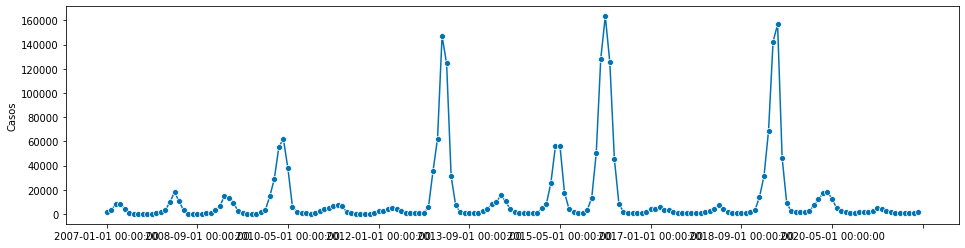

In [ ]:
from sktime.utils.plotting import plot_series

# plotting for visualization
plot_series(y_all['Casos'])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8e8b0050>)

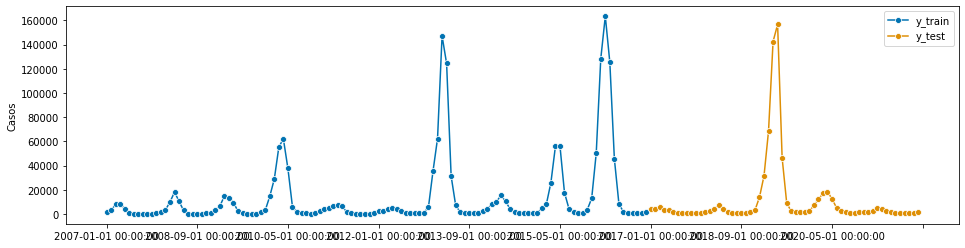

In [ ]:
from sktime.utils.plotting import plot_series

# plotting for illustration
plot_series(y_train['Casos'], y_test['Casos'], labels=["y_train", "y_test"])

In [ ]:
# Horizonte de previsão
p_tst = pd.date_range(start='2017-01-01', end='2021-12-31', freq='M')
p_idx = pd.date_range(start='2022-01-01', end='2022-12-31', freq='M')
p_idx

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='M')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae8e718b50>)

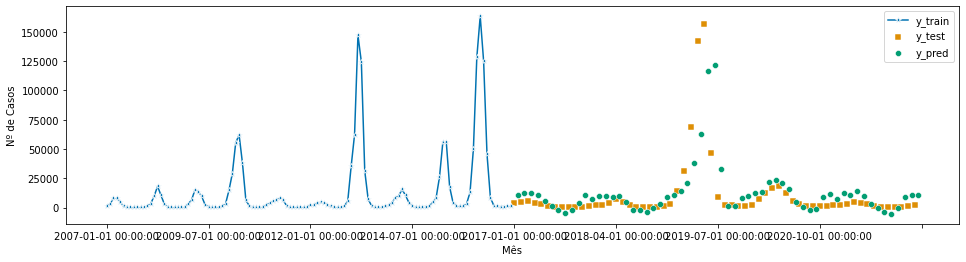

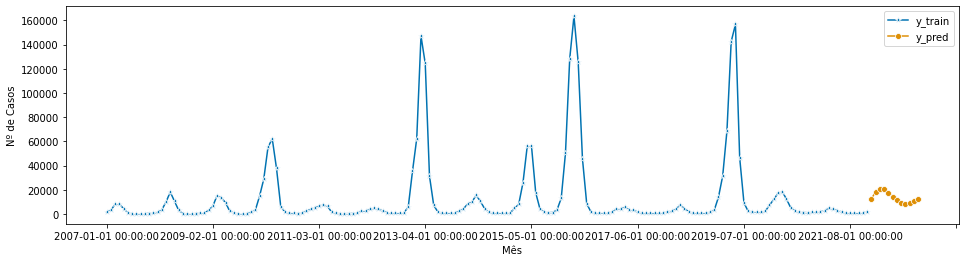

In [ ]:
from sktime.forecasting.var import VAR

forecaster = VAR()

# Avaliação
y = y_all
forecaster.fit(y)
y_pred = forecaster.predict(fh=p_tst)
plot_series(y_train['Casos'], y_test['Casos'], y_pred['Casos'], labels=["y_train", "y_test", "y_pred"], x_label='Mês', y_label='Nº de Casos', markers=['*', 's', 'o'])

# 2022
y = y_all
forecaster.fit(y)
y_pred2 = forecaster.predict(fh=p_idx)
plot_series(y_all['Casos'], y_pred2['Casos'], labels=["y_train", "y_pred"], x_label='Mês', y_label='Nº de Casos', markers=['*', 'o'])


In [ ]:
val_y_test = scaler.inverse_transform(y_test)
val_y_pred = scaler.inverse_transform(y_pred)
mean_squared_error(val_y_test, val_y_pred, squared=True)

1.5255851819231265e+18

In [ ]:
mean_squared_error(y_test, y_pred, squared=True)

57267164.42184843